In [74]:
!pip install yfinance 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
"""
Created on Fri Dec 16 17:47:47 2022

# Here we write our portfolio optimization project

@author: Bilal
"""
import pandas as pd
import datetime
import numpy as np
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize.minpack import dtype
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

# Helper Functions
def rand_weight(Tickers):
  '''
    geneerate random portfolio weights.

    Parameters
    ----------
    Tickers: List of stock tickers in the portfolio

    Returns
    -------
    x : List of floats(doubles)
        representing random weights/allocations in each ticker
    '''
  x = np.random.random(len(Tickers))
  x /= x.sum()
  return x

def Portfolio_DailyReturns(Tickers, start, end):
    '''
    generate the daily % returns of AdjClose Price

    Parameters
    ----------
    Tickers : List of str
        All Tickers in portfolio
    start : datetime starting obj
        initial starting date of portfolio
    end : datetime ending obj
        cut-off for date time

    Returns
    -------
    Pandas DataFrame of pct_returns

    '''
    df = yf.download(Tickers, start = start, end = end)['Adj Close'].dropna()
    df = df.pct_change()[1:] # drop NAN first row
    return df

def Annualized_Return(df_returns):
    '''
    calculate annualized returns

    Parameters
    ----------
    df : Pandas df
        df of Daily returns of assets

    Returns
    -------
    np.array of returns

    '''
    r = np.array((df_returns + 1).prod() ** (252/len(df_returns) ) - 1)
    return r

def Expected_Returns(r,w):
    '''
    calculate expected returns

    Parameters
    ----------
    r : annualized returns of assets
        doubles

    Returns
    -------
    expected return: double

    '''
    return  np.dot(r,w )

def Expected_Risk(cov,w):
    '''
    calculate expected risk

    Parameters
    ----------
    cov : cov matrix 
    w: np.array of weights

    Returns
    -------
    expected risk: double

    '''
    return np.dot(np.dot(cov, w), w) 

def simulate_portfolios(tickers, Nsims, start, end):
    '''
    generates different portfolios and their return/risk/weights
    for the time horizon

    Parameters
    ----------
    tickers : list of stock tickers
        list of strs
    Nsims: num of sims
      int
    start/end: starting/ending time
      datetime obj
    
    Returns
    -------
    pd.DataFrame of returns,risks and allocations

    '''
    r = []
    std = []
    w = []
    port_dailyr = Portfolio_DailyReturns(tickers, start, end)
    mu = Annualized_Return(port_dailyr)
    covar = port_dailyr.cov()
    for i in range(Nsims):
        weights = rand_weight(tickers)
        r.append(Expected_Returns(mu, weights))
        std.append( Expected_Risk(covar, weights) )
        w.append(weights)
    return pd.DataFrame({'Expected Return': r, 'Risk': std, 'Weights':w})

def naive_sharpe(portf, rf ):
    '''
    approximate sharpe of simulations (helper to simulate_portfolio)
    prints sharpe ratio estimate

    Parameters
    ----------
    portf : pd.DataFrame with Expected Return and Risk columns

    Returns
    -------
    list: expected return, risk, allocation

    '''
  # take in portfolio
    sharpe_index = ( (portf['Expected Return'] - rf)/portf['Risk']).idxmax()
    r = portf['Expected Return'][sharpe_index]
    std = portf['Risk'][sharpe_index]
    w = portf['Weights'][sharpe_index]
    
    sharpe_ratio = (portf['Expected Return'][sharpe_index] - rf)/portf['Risk'][sharpe_index]
    print(
        f"Naive Guessimate \n The Max Sharpe Ratio: {sharpe_ratio} \n Expected Return: {r} \n Expected Risk: {std} \n Optimal Allocation: {w}"
        )
    return [r,std,w]

def Sharpe_Solver(df,rf):
    '''
    solve for sharpe ratio
    prints sharpe ratio estimate

    Parameters
    ----------
    daily: pd.DataFrame with daily returns of portfolio

    Returns
    -------
    list: expected return, risk, allocation

    '''
    mu = Annualized_Return(df)
    cov = df.cov()
    
    weights = np.ones(df.shape[1])
    #print(df.shape[1])
    bounds = Bounds(0,1)
    linear_constraint = LinearConstraint(np.ones((df.shape[1]),dtype = int ), 1, 1)
    fun = lambda w: Expected_Risk(cov,w) / (Expected_Returns(mu, w) - rf)
    x0 = weights/np.sum(weights)
    res = minimize(fun, x0, method = 'trust-constr', constraints = linear_constraint, bounds = bounds)
    optimal_w = res.x
    
    r = Expected_Returns(mu, optimal_w)
    std = Expected_Risk(cov,optimal_w)
    sharpe_ratio = (r - rf)/std
    print(
        f"Solver Solution \n The Max Sharpe Ratio: {sharpe_ratio} \n Expected Return: {r} \n Expected Risk: {std} \n Optimal Allocation: {optimal_w}"
        )
    return [r,std, optimal_w]

def generate_frontier():
  pass


In [76]:
# plotting functions 

def plot_universe(universe,tickers,legend,rf):
  '''
  plotting function for portfolio universe
  prints sharpe ratio estimate

  Parameters
  ----------
  universe: universe df obj with returns and risks
  legend: str input of b or s for sharpe point
  rf: risk free rate

  Returns
  -------
  list: expected return, risk, allocation

  '''
  from matplotlib.ticker import FormatStrFormatter
  from matplotlib.ticker import StrMethodFormatter

  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.6f}')) # 2 decimal places
  plt.rcParams["figure.figsize"] = [17.50, 13.50]
  plt.rcParams["figure.autolayout"] = True
  c = universe['Expected Return']
  plt.scatter(universe['Risk'], universe['Expected Return'], c = c, cmap = 'inferno' )
  plt.xlabel("Risk (Volatility/Standard Deviation)")
  plt.ylabel("Expected Returns")
  plt.title("Portfolio Universe")
  if legend == "a":
    ns = naive_sharpe(universe, rf)
    plt.plot( ns[1] , ns[0], marker = '*' , markersize = 30)
    plt.text(ns[1] , ns[0], "Naive estimate of Sharpe Ratio")
    d = Portfolio_DailyReturns(tickers, start, end)
    sharpe = Sharpe_Solver(d,rf)
    plt.plot( sharpe[1] , sharpe[0], marker = '*', markersize = 30 )
    plt.text(sharpe[1] , sharpe[0], "Optimal Portfolio (Best Sharpe)")
    min_risk = EfficientP_Solver(d)
    plt.plot( min_risk[1] , min_risk[0], marker = '*', markersize = 30 )
    plt.text(min_risk[1] , min_risk[0], "Optimal Portfolio (Lowest Risk)")    
  elif legend == "s":
    d = Portfolio_DailyReturns(tickers, start, end)
    sharpe = Sharpe_Solver(d,rf)
    plt.plot( sharpe[1] , sharpe[0], marker = '*', markersize = 30 )
    plt.text(sharpe[1] , sharpe[0], "Optimal Portfolio (Best Sharpe)")
  plt.show()
  return None







In [77]:

'''
ETFS TRACKING DIFFERENT SECTORS OF ECONOMY
Basic Materials XLB
Consumer Cyclical XLY
Financial Services XLF
Realestate VNQ
Consumer Defensive XLP
Healthcare XLV
Utilities XLU
Communication Services XTL
Energy XLE
Industrials XLI
Technology XLK

MUTUAL FUNDS
Fidelity Contrafund FCNTX
Pioneer A PIODX
American Funds Invmt Co of Amer A AIVSX
Parnassus Core Equity Investor PRBLX
Vanguard 500 Index Admiral VFIAX
SP500 ^GSPC
'''
ETFS = ['XLB', 'XLY', 'XLF', 'VNQ', 'XLP', 'XLV', 'XLU', 'XTL', 'XLE', 'XLI', 'XLK']
MutualFunds = ['FCNTX', 'PIODX', 'AIVSX', 'PRBLX', 'VFIAX','^GSPC']

start = datetime.datetime(2012,12,1)
end = datetime.datetime(2021,12,1)

In [78]:
daily = Portfolio_DailyReturns(ETFS, start, end)
# our etfs daily returns
daily.head()

[*********************100%***********************]  11 of 11 completed


,VNQ,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2012-12-04,0.001551,0.001944,-0.003679,-0.002548,0.003812,-0.001719,-0.001950,-0.005128,0.002241,-0.004230,0.004292
2012-12-05,-0.003097,-0.011915,0.006959,0.012133,0.010577,-0.009986,0.001675,0.015178,0.003231,-0.002974,-0.000450
2012-12-06,0.009321,0.002524,0.003243,0.003154,-0.000268,0.005913,0.001114,-0.000565,-0.000495,0.006391,0.000000
2012-12-07,0.003694,0.008392,0.006046,0.008176,0.006443,-0.005187,0.006958,0.000847,0.003222,0.003810,0.002475
2012-12-10,-0.000460,0.006380,-0.001118,-0.002495,0.005068,0.002433,-0.001105,0.000282,0.004200,-0.005693,0.006734


In [79]:
# covariance matrix for etfs
daily.cov()

,VNQ,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XTL
VNQ,0.000150,0.000098,0.000117,0.000110,0.000102,0.000096,0.000077,0.000104,0.000081,0.000093,0.000088
XLB,0.000098,0.000156,0.000167,0.000140,0.000133,0.000117,0.000073,0.000073,0.000093,0.000109,0.000111
XLE,0.000117,0.000167,0.000322,0.000182,0.000161,0.000127,0.000077,0.000079,0.000101,0.000124,0.000132
XLF,0.000110,0.000140,0.000182,0.000186,0.000145,0.000124,0.000079,0.000076,0.000102,0.000119,0.000118
XLI,0.000102,0.000133,0.000161,0.000145,0.000146,0.000118,0.000075,0.000076,0.000095,0.000112,0.000111
XLK,0.000096,0.000117,0.000127,0.000124,0.000118,0.000166,0.000077,0.000071,0.000103,0.000124,0.000119
XLP,0.000077,0.000073,0.000077,0.000079,0.000075,0.000077,0.000080,0.000074,0.000068,0.000069,0.000062
XLU,0.000104,0.000073,0.000079,0.000076,0.000076,0.000071,0.000074,0.000134,0.000067,0.000064,0.000059
XLV,0.000081,0.000093,0.000101,0.000102,0.000095,0.000103,0.000068,0.000067,0.000112,0.000089,0.000084
XLY,0.000093,0.000109,0.000124,0.000119,0.000112,0.000124,0.000069,0.000064,0.000089,0.000127,0.000106


[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed
Naive Guessimate 
 The Max Sharpe Ratio: 1653.9531476057155 
 Expected Return: 0.1611424190802594 
 Expected Risk: 9.742864803246168e-05 
 Optimal Allocation: [0.03251236 0.03691541 0.0021726  0.02419677 0.00412381 0.18727308
 0.10845765 0.08500599 0.18267958 0.22417745 0.11248528]
[*********************100%***********************]  11 of 11 completed
Solver Solution 
 The Max Sharpe Ratio: 1821.1934525561412 
 Expected Return: 0.16168347875066233 
 Expected Risk: 8.877886010611943e-05 
 Optimal Allocation: [1.02529876e-04 4.87281916e-05 1.23470454e-05 2.43053611e-05
 6.26613397e-05 1.57514885e-01 2.78702370e-01 8.72798376e-02
 1.93682849e-01 2.82487217e-01 8.22695268e-05]
Min Risk Portfolio 
Expected Return: 0.11675500060423398 
 Expected Risk: 7.638079888644034e-05 
 Optimal Allocation: [0.00492148 0.00480702 0.00219207 0.00238594 0.00380347 0.

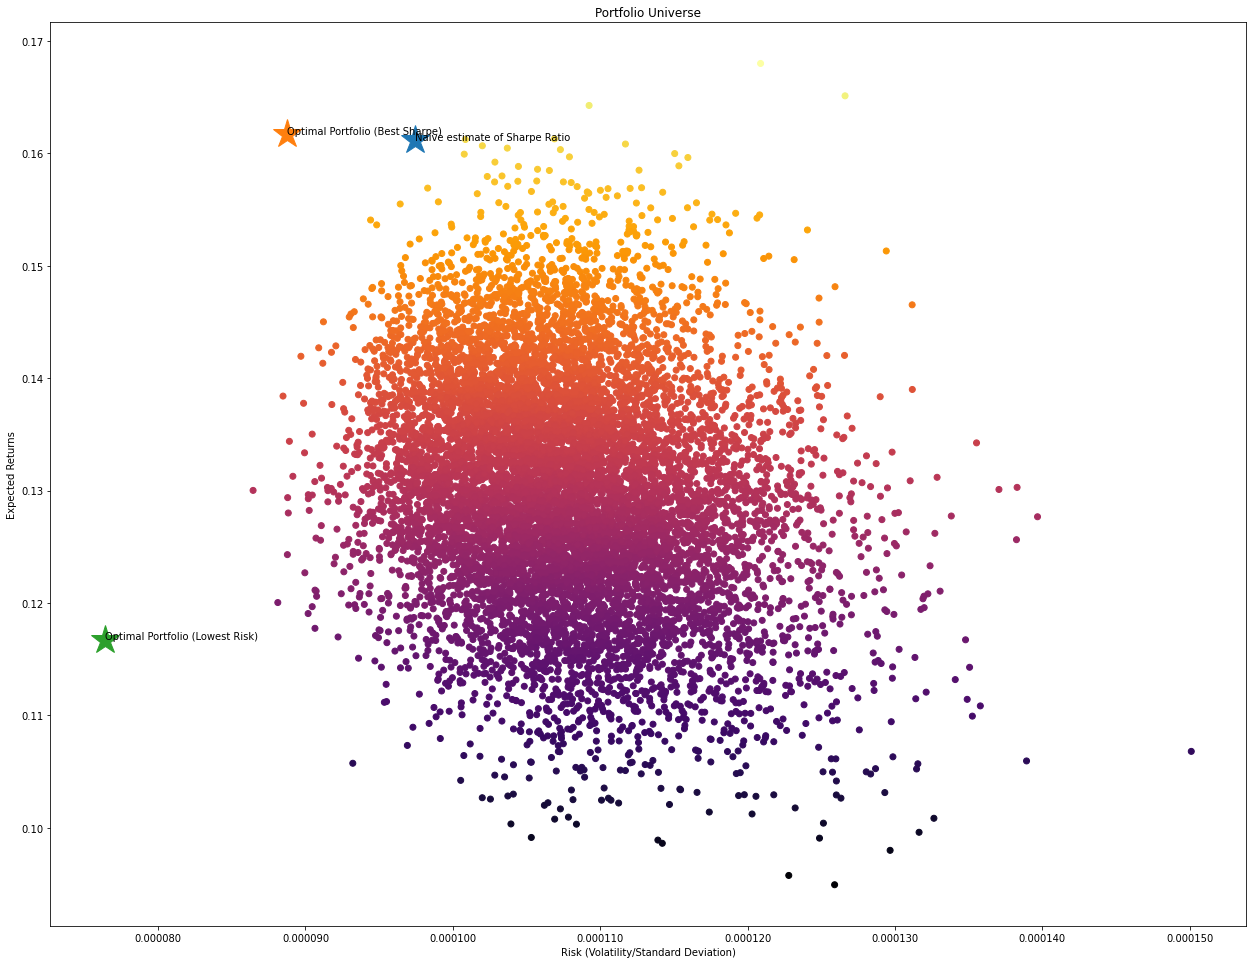

In [80]:
daily = Portfolio_DailyReturns(ETFS, start, end)
universe = simulate_portfolios(ETFS, 10000,start, end)
plot_universe(universe, ETFS, 'a', 0)



In [81]:
# now we want to backtest our strategy against mutual funds and sp500
# benchmark returns from end of research data to yesterday's closing
b_start = datetime.datetime(2021,12,2)
b_end = datetime.date.today() - datetime.timedelta(days = 1)
optimal_w = Sharpe_Solver(daily,0)[2]

Solver Solution 
 The Max Sharpe Ratio: 1821.1919817879375 
 Expected Return: 0.16168337366940272 
 Expected Risk: 8.877887410347131e-05 
 Optimal Allocation: [1.02530039e-04 4.87273026e-05 1.23469573e-05 2.43057385e-05
 6.26619668e-05 1.57513912e-01 2.78701507e-01 8.72807025e-02
 1.93684337e-01 2.82486699e-01 8.22708304e-05]


In [82]:
# Creating the efficient frontier and the standard Markowitz objective function of just minimizing variance
def EfficientP_Solver(df):
    '''
    solve for portfolio with lowest variance
    prints sharpe ratio estimate

    Parameters
    ----------
    daily: pd.DataFrame with daily returns of portfolio

    Returns
    -------
    list: expected return, risk, allocation

    '''
    mu = Annualized_Return(df)
    cov = df.cov()
    
    weights = np.ones(df.shape[1])
    #print(df.shape[1])
    bounds = Bounds(0,1)
    linear_constraint = LinearConstraint(np.ones((df.shape[1]),dtype = int ), 1, 1)
    fun = lambda w: Expected_Risk(cov,w) 
    x0 = weights/np.sum(weights)
    res = minimize(fun, x0, method = 'trust-constr', constraints = linear_constraint, bounds = bounds)
    optimal_w = res.x
    
    r = Expected_Returns(mu, optimal_w)
    std = Expected_Risk(cov,optimal_w)
    
    print(
        f"Min Risk Portfolio \nExpected Return: {r} \n Expected Risk: {std} \n Optimal Allocation: {optimal_w}"
        )
    return [r,std, optimal_w]
  
efficient_w = EfficientP_Solver(daily)[2]

Min Risk Portfolio 
Expected Return: 0.11675493573958876 
 Expected Risk: 7.638078689421981e-05 
 Optimal Allocation: [0.00492145 0.00480696 0.00219207 0.00238594 0.00380348 0.00279277
 0.64067341 0.08003658 0.1227463  0.03370758 0.10193344]


In [83]:
# create benchmarking function for comparing max_sharpe allocation vs benchmark like SP500
def BackTest_Performance(portfolio_tickers,portfolio_w ,benchmark_tickers, start, end):
# takes in current optimal_w, tickers of portfolio, benchmark ticker, timeline for benchmark
  # computes returns of portfolio strategy at each day
  daily_port = Portfolio_DailyReturns(portfolio_tickers, start, end)
  daily_bench = Portfolio_DailyReturns(benchmark_tickers, start, end)
  cum_port = (1 + daily_port).cumprod()
  cum_bench = (1 + daily_bench).cumprod()
  daily_value_port = np.zeros(cum_port.shape[0])

  # if timeline greater than 1 year
  # start of each year re allocate weights for max sharpe
  for i in range(cum_port.shape[0]):
    daily_value_port[i] = np.dot(cum_port.iloc[i,],portfolio_w)
  # plot value of portfolio against value of benchmark
  #plt.hist(daily_value_port, label = "Portfolio Value")
  #plt.hist(daily_bench, label = "Portfolio Value")
  plt.plot(cum_port.index, daily_value_port, label = "Portfolio Returns", linestyle = 'solid')
  for i in range(len(benchmark_tickers)): 
    plt.plot(cum_port.index, cum_bench.iloc[:,i], label = f"{benchmark_tickers[i]} Returns", linestyle = 'dashed')
  plt.legend()
  plt.show()

  annual_strat = Annualized_Return(daily_port)
  annual_bench = Annualized_Return(daily_bench)
  print(f"The expected returns of our strategy is {Expected_Returns(annual_strat,portfolio_w)}")
  for i,b in enumerate(annual_bench):
    print(f"{benchmark_tickers[i]} has an annualized return of {b}")
  #plt.plot(daily_value_port)
  # can plot returns of portfolio against returns of benchmark (possible PNL?)

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  6 of 6 completed


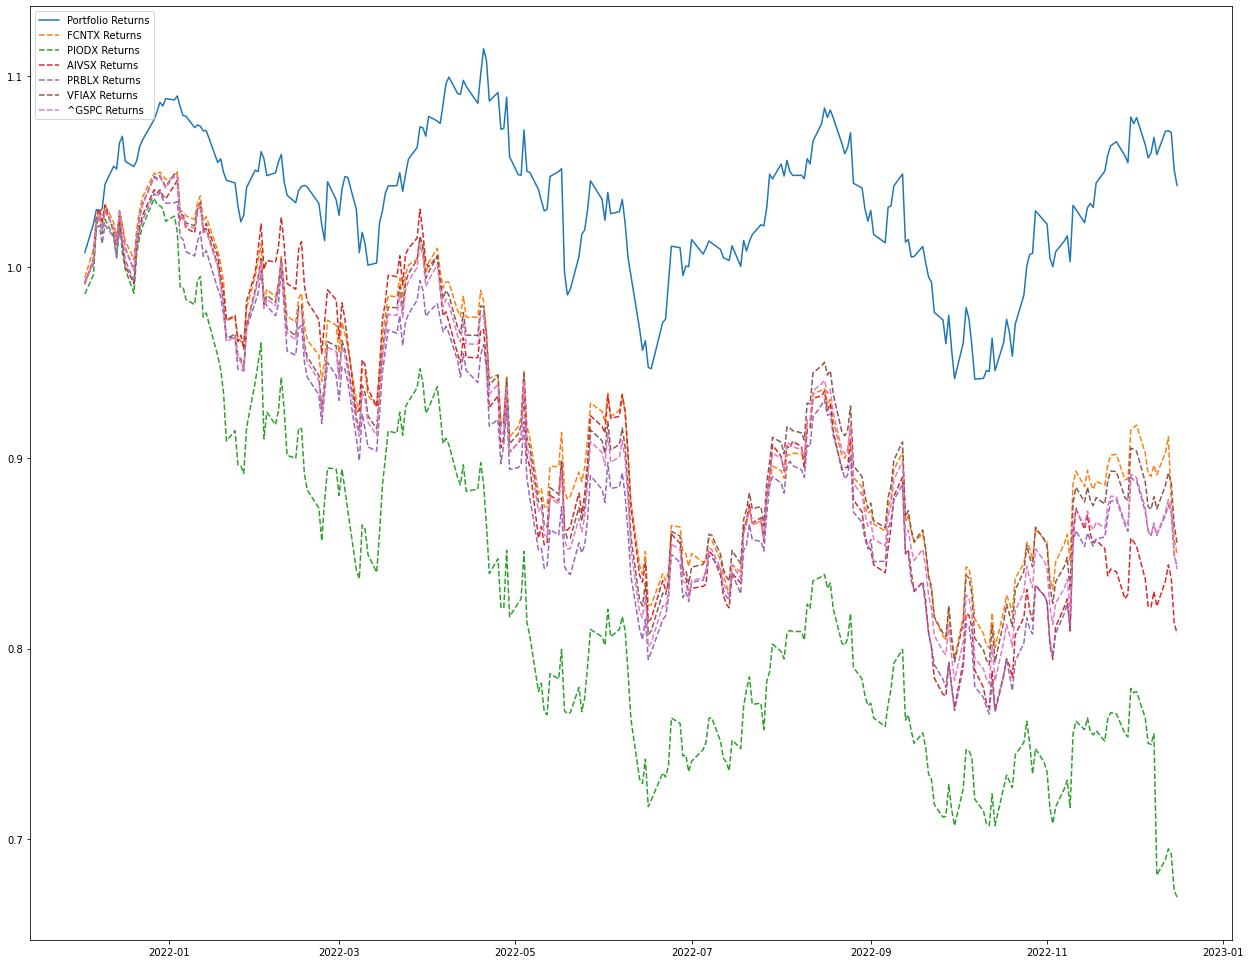

The expected returns of our strategy is 0.04086834980976232
FCNTX has an annualized return of -0.14478267273506518
PIODX has an annualized return of -0.32004810900416547
AIVSX has an annualized return of -0.185505233307238
PRBLX has an annualized return of -0.15142139853515624
VFIAX has an annualized return of -0.13956622847477274
^GSPC has an annualized return of -0.15278457647773735
None


In [84]:
print(BackTest_Performance(ETFS,efficient_w ,MutualFunds, b_start, b_end) )

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  6 of 6 completed


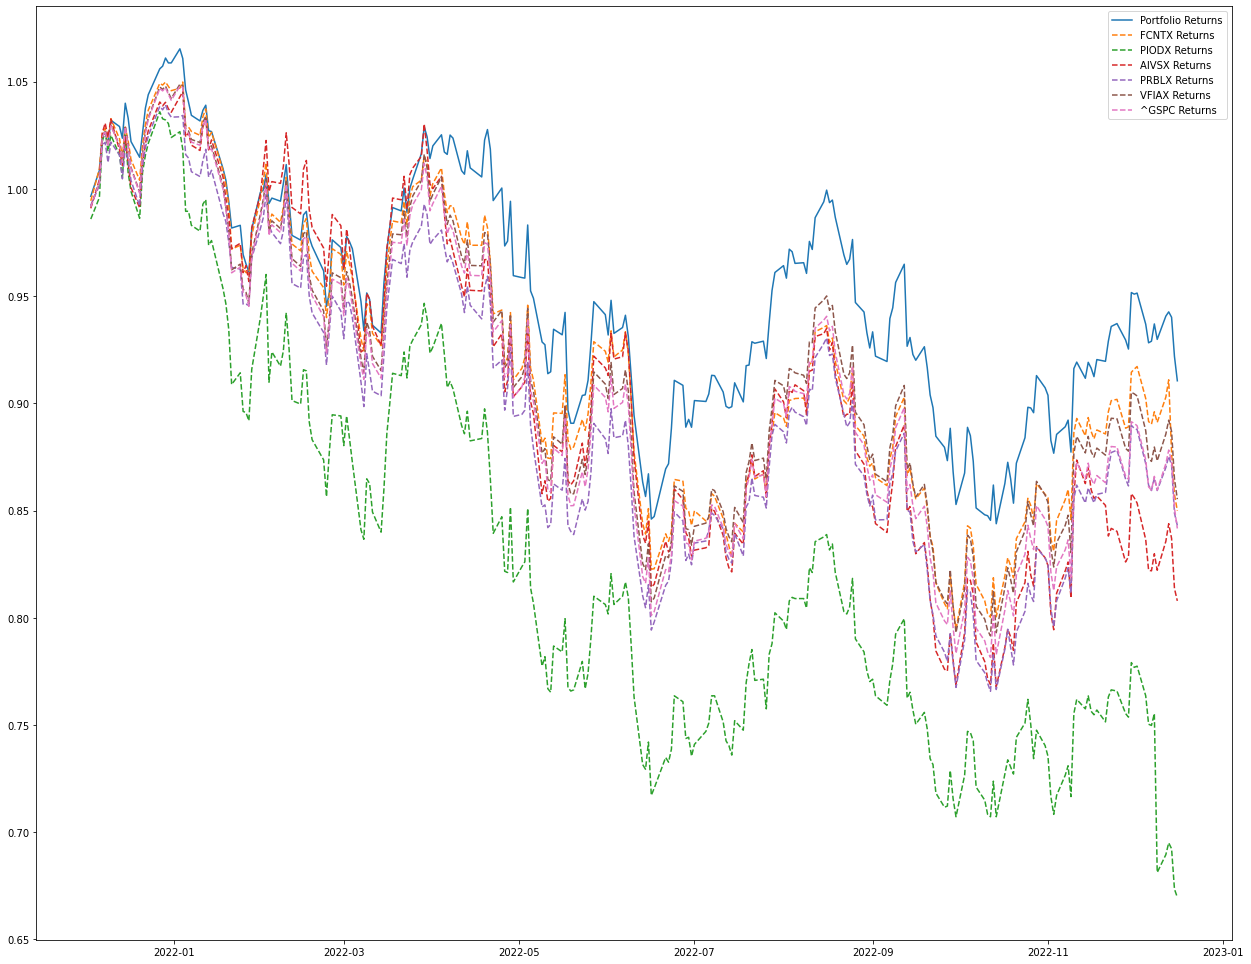

The expected returns of our strategy is -0.0869691553984546
FCNTX has an annualized return of -0.14478260779805763
PIODX has an annualized return of -0.32004810900416547
AIVSX has an annualized return of -0.18550523330723823
PRBLX has an annualized return of -0.15142134281648834
VFIAX has an annualized return of -0.13956622847477362
^GSPC has an annualized return of -0.15278457647773735
None


In [85]:
print(BackTest_Performance(ETFS,optimal_w ,MutualFunds, b_start, b_end) )

Our portfolio optimization strategy overperforms against mutual funds in this current downturning market. This is true for both strategies, though this means we are not too sensitive to volatility (refer to objective functions we minimize). This also means in bull years, we probably underperform against these funds.